![DLI Logo](../assets/DLI_Header.png)

# Introduction

In this module, you will learn how about model **evasion** -- specifically closed-box evasion where you have limited access to the mdoel.

_model evasion_: Generating a sample to intentionally get misclassified while preserving some other property (such as human imperceptibility). 

## Learning Objectives:

1. Improve understanding of evasion attacks under limited-knowledge conditions.

```{tip} Table of Contents
For easier navigation, select _Table of Contents_ from the _View_ menu.
```

# Evasion

In this lesson, we will cover the following topics.

You've done some open-box evasion, now we'll then make the problem a bit harder.  Next, we'll implement a simplified version of a gray-box attack called SimBA (you can read the paper [here](https://arxiv.org/abs/1905.07121) ), where we cannot access the model weights, but we do get classifier confidence scores; we'll do this in both an untargeted and a targeted version, and show how sufficient interactive access to the model lets you estimate gradients well enough to still perform an attack.

Finally, we'll walk through the hardest case with the most complicated attack: a full black-box attack when the only information you have is the model's final decision about the most likely class: no gradients, no confidence scores.  We'll introduce the HopSkipJump attack (paper [here](https://arxiv.org/abs/1904.02144) -- figure 2 on page 5 might be helpful to have open as you work) and walk through a simplified implementation step by step.  

### Imports and Model Loading
We'll setup the same environment and targets you had in notebook 1.

In [1]:
# DO NOT CHANGE

import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# DO NOT CHANGE

#load the model from the pytorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
model.eval()

# put the model on a GPU if available, otherwise CPU
model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

with open("data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

img = Image.open("data/dog.jpg")
img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)

print(f"Image tensor on device:\n---------------\n{img_tensor.device}\n")
print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\nclass: {type(img_tensor)}\n")
print(f"Shape of outputs:\n---------------\n{output.shape}\n")
print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax()]}\n")

unnormed_img_tensor= unnormalize(img_tensor)

img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0])
img_pil.show()

Image tensor on device:
---------------
cuda:0

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])
class: <class 'torch.Tensor'>

Shape of outputs:
---------------
torch.Size([1, 1000])

Pred Index:
---------------
235

Pred Label:
---------------
German shepherd



## SimBA (Simple BlackBox Attack)
The reason the open box attacks work _so_ well is because we have complete access to the model, and so we can compute gradients through the model all the way to the image mask, as if they were parameters. But what happens if we only have access to the model scores (outputs of the last layer)? In this case, we can't compute the exact gradient of the loss with respect to the individual mask parameters, so we must find a new way.

Remember earlier in this lab, when we asked you (seemingly arbitrarily) to make a bunch of random queries using random images. And then we said "it's going to be useful" and it wasn't clear why? Well now we're to show you. We're going to take our 'random search' idea and adapt it slightly; instead of simply guessing complete images at random, we're going to construct a lot of random _masks_ and then essentially play hot-and-cold; we can test each random mask and see if it reduces or increases our new loss function. If a random mask reduces the loss, we take the step. By doing a lot of these steps, we can ultimately fumble our way _approximately_ towards the decision boundary (where German Shepherd changes to some other class) without ever having computed an exact gradient! The method we'll show here is a simplified (and less efficient) implementation of the [SimBA paper](https://arxiv.org/abs/1905.07121) (algorithm 1 on page 3).

The key thing to note here is that we're still using the same loss function, we're just optimizing it in a slightly different manner.

Let's reset our images and what not, notice we're starting with _only_ the image, no optimizer.

In [3]:
# DO NOT CHANGE

# create new img_tensor
img_tensor = preprocess(img).unsqueeze(0).to(device)

### Generater Random Masks
Here, we generate random masks. `1000` will do for now, and we'll add a tiny bit of noise via the `eta` argument (remember that we set rng manually).

In [4]:
# DO NOT CHANGE

n_masks = 1000
eta = 0.005

mask_collection = torch.randn((n_masks, *img_tensor.shape)).to(device)*eta

current_mask = torch.zeros_like(img_tensor).to(device)

In [5]:
print(mask_collection.shape)
print(current_mask.shape)

torch.Size([1000, 1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


We set our initial sample and get some initial feedback from the model, before running the attack.

In [6]:
# DO NOT CHANGE

# compute our starting index
starting_index = model(img_tensor).argmax(1)
print(f"Starting index is:\n---------------\n{starting_index}\n")

starting_class_score = model(img_tensor + current_mask)[0, starting_index.item()].item()
print(f"Starting class score is:\n---------------\n{starting_class_score}\n")

Starting index is:
---------------
tensor([235], device='cuda:0')

Starting class score is:
---------------
5.69329309463501



Don't worry about trying to remember the index, at a certain point it doesn't matter, like right now. Especially when that dog can be anything...or anything can be anything...

### Run the Untargeted Attack
Remember, as we submit random inputs to the model, we want the score (roughly: probability) for the true label to go down. Attack!



In [7]:
# DO NOT CHANGE

# Zero our current mask
current_mask = torch.zeros_like(img_tensor).to(device)

# Get our starting label index
starting_label = model(img_tensor).argmax(1)
current_label = starting_label

# Get our starting confidence score
best_score = model(img_tensor + current_mask)[0, starting_index.item()].item()

# Run until we reclassify successfully ...
while current_label == starting_label:

    # Select a random mask from the collection we created
    mask_candidate_idx = np.random.choice(len(mask_collection))
    mask_candidate = mask_collection[mask_candidate_idx]

    # Don't store gradient information while doing inference
    with torch.no_grad():
        # get the scores for the image if we updated the current mask to
        # use the candidate we just randomly picked
        output = model(img_tensor + current_mask + mask_candidate)
    
    # select the most probable label from the output of the model with the candidate mask in play
    current_label = output.argmax(1).item()
    # our score will be the score of our original label: we want this to go _down_ (i.e. the current
    # label to become less likely)
    new_score = output[0, starting_label.item()].item()

    # If the score for the current class -- the one we're trying to get away from -- did not decrease, then
    # skip back to the beginning and pick another candidate mask
    if new_score >= best_score:
        continue

    # If we got to here, then we decreased the score of the true class for the image; this means
    # the score for some other class went up, and at some point if we get the score for the true 
    # label low enough, some other class will be the maximum and we will have successfully misclassified.
    
    
    # Write some monitoring for dopamine 
    print(f"Best score is: {best_score:4.6f} -- prediction is: {current_label}  ", end='\r', flush=True)
    
    # Update our current score
    best_score = new_score
    
    # And update our mask
    current_mask += mask_candidate
                
print(f"\n\nWinner winner: {labels[output[0].argmax()]} ({output[0].argmax()})")

Best score is: 3.701300 -- prediction is: 231  

Winner winner: collie (231)


Then we visualize it, being careful to make sure we're looking at `img_tensor + current_mask`

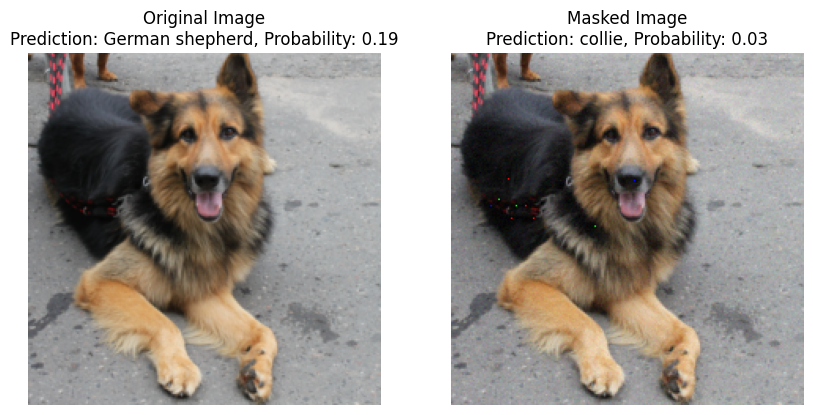

In [8]:
# DO NOT CHANGE

with torch.no_grad():
    output = model(img_tensor)
    masked = model(img_tensor + current_mask)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    unnormed_img_tensor= unnormalize(img_tensor)
    unnormed_mask_tensor= unnormalize(img_tensor + current_mask)

    img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0])
    masked_pil = transforms.functional.to_pil_image(unnormed_mask_tensor[0])
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction}, Probability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

You might even be able to see some broken pixels in the generated image!

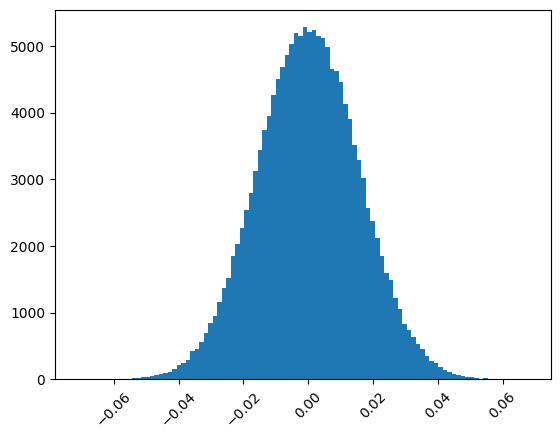

Minimum and maximum difference between the images: -0.07123078405857086 0.06792557239532471


In [9]:
# DO NOT CHANGE

difference = unnormed_mask_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())

## Write a Targeted Attack

:::{exercise}
That was an untargeted attack, what about a targeted attack?

1. Modify the above code to perform a targeted adversarial evasion: make the German Shepherd look like a robin.

Hint: we're making our starting class score go down in the example above -- how could you make the target class score go up instead?


```python

n_masks = 1000
eta = 0.01

mask_collection = torch.randn((n_masks, *img_tensor.shape)).to(device)*eta
current_mask = torch.zeros_like(img_tensor).to(device)

# Get our starting label index
starting_label = model(img_tensor).argmax(1).item()
current_label = starting_label

# Get our starting confidence score
best_score = model(img_tensor + current_mask)[0, target_index.item()].item()

# Run until we reclassify successfully ...
while current_label != target_index:

    # Select a random mask from the collection we created
    mask_candidate_idx = np.random.choice(len(mask_collection))
    mask_candidate = mask_collection[mask_candidate_idx]

    # Don't store gradient information while doing inference
    with torch.no_grad():
            
            #
            #
            # Your code here!
            #
            #
print(f"\n\nWinner winner: {labels[output[0].argmax()]}")
```

Success criteria:
- The model says the image of the german shepherd is a robin
- The image isn't too corrupted (for subjective values of "too corrupt")

What we want you to get out of this:
- Make sure you understand the code above; read through the comments carefully, and see if you can figure out how to move _towards_ a target class rather than _away_ from the current class.  Think about what entry in the output vector to look at, and how you want it to change.  


:::

In [10]:
# provided code
target_index = torch.tensor(labels.index('robin')).unsqueeze(0).to(device)
print(f"Target index is:\n---------------\n{target_index}\n")

target_class_score = model(img_tensor + current_mask)[0, target_index.item()].item()
print(f"Target class score is:\n---------------\n{target_class_score}\n")

Target index is:
---------------
tensor([15], device='cuda:0')

Target class score is:
---------------
-0.641310453414917



In [12]:
# your code here
n_masks = 1000
eta = 0.01

mask_collection = torch.randn((n_masks, *img_tensor.shape)).to(device)*eta
current_mask = torch.zeros_like(img_tensor).to(device)

# Get our starting label index
starting_label = model(img_tensor).argmax(1).item()
current_label = starting_label

# Get our starting confidence score
best_score = model(img_tensor + current_mask)[0, target_index.item()].item()

# Run until we reclassify successfully ...
while current_label != target_index:

    # Select a random mask from the collection we created
    mask_candidate_idx = np.random.choice(len(mask_collection))
    mask_candidate = mask_collection[mask_candidate_idx]

    # Don't store gradient information while doing inference
    with torch.no_grad():
            
            #
            #
            # Your code here!
            output = model(img_tensor + current_mask + mask_candidate)
            #
    current_label = output.argmax(1).item()
    new_score = output[0, target_index.item()].item()
    
    if new_score < best_score:
        continue
    print(f"Best score is: {best_score:4.6f} -- pred score is: {output[0, current_label].item()} -- prediction is: {current_label}  ", end='\r', flush=True)
    
    best_score = new_score
     # And update our mask
    current_mask += mask_candidate
print(f"\n\nWinner winner: {labels[output[0].argmax()]}")

Best score is: 4.203716 -- pred score is: 4.206926345825195 -- prediction is: 15     

Winner winner: robin


The solution for this exercise can be found in the [answer key](answers-2_evasion-closed-box.ipynb).

While it might not be immediately obvious, sampling a lot of random mask updates and seeing what happens to the score is in fact a kind of gradient estimation. By seeing what happens to the model score when we perturb the model in several different directions, we can have a loose sense of how sensitive the loss is to various changes in the parameters in question, which is (essentially) what the gradient is used for.  The HopSkipJump attack -- one of the better black box attacks against image classifiers at the moment -- uses this trick extensively.

# HopSkipJump by Hand
The previous examples all relied on being able to compute or estimate model gradients based on probabilistic outputs to find an extremely efficient adversarial perturbations extremely quickly. In practice however, we're often attacking a model on the other side of an API and only get labels (no scores or probabilities), dog, cat, sheep, parrot, etc. In this case, there are better algorithms to choose - The most widely used one is "HopSkipJump" (if only because we tend to use it the most) -- the details of this approach are complex, but the general plan of attack is as follows:

1. Add random noise to get _any_ kind of misclassification -- alternatively, use a second image.
2. Interpolate between the images until you find the mask that just barely changes your starting image to the new class.
3. Estimate the best direction to go to increase the misclassification strength; "jump" in that direction to create a new second image.
4. Repeat step 2 and 3 until you get a stable result.

It's worth remarking here that -- even though the classifier does have full access to the model and can compute gradients directly on it -- the HSJ attack does not use that ability.

The original paper is [here](https://arxiv.org/abs/1904.02144) -- skip to page 5 for a diagram that gives you a conceptual view of the attack. You'll notice that there is a lot of extremely intimidating looking math all throughout the paper. If you read closely, you'll notice that most of it is an exercise in proving that the attack should work mathematically, and as long as we're willing to trust them on that, we can ignore it (hooray). The core elements to perform the attack are more straightforward and can be understood at a high level from the algorithm listings and the figures. 

This is _entirely_ typical for this space; as you read more papers, you'll develop a better intuition for what is academic boilerplate that you can ignore entirely, and what to focus on. The important thing to focus on here are what the attack actually does, and how to translate it from the dense academic jargon into something you can implement. We are going to walk through a single iteration of this attack by hand, the full code implementation is in `hop_skip_jump.py`. 

Again, let's reset our image. Just in-case... 

In [6]:
# DO NOT CHANGE

# create new img_tensor
img_tensor = preprocess(img).unsqueeze(0).to(device)

# move sample to the right device
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)
    
y_original = output[0].argmax()
  
print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax().item()]}\n")

Pred Index:
---------------
235

Pred Label:
---------------
German shepherd



First, let's define a success function -- the predicted class does not match the target. Boom. Done. 

In [21]:
?torch.clamp

In [8]:
# DO NOT CHANGE

def adversarial_satisfactory(samples, target, clip_min, clip_max):
    samples = torch.clamp(samples, clip_min, clip_max)
    
    with torch.no_grad():
        preds = model(samples).argmax(dim=1)
    
    # any other class
    result = preds != target
    return result

We're going to routinely clamp the images to this range to make sure that the algorithm doesn't "cheat" by giving us an image that could never be generated from a 24-bit image. For example, a pixel value of `168.384` in invalid, even if the model can work with it! As you run these experiments make extra sure your constraints are respected. 

In [7]:
# DO NOT CHANGE

# We're going to routinely clamp the images to this range to make sure that the algorithm doesn't "cheat" by giving us an image that could never be generated from a 24-bit image.
clip_min = -2
clip_max = +2

# randomly seed the generator
generator = torch.Generator().manual_seed(0)

The first step in this attack is the creation of a single misclassified image to serve as an "anchor" on the other side of the decision boundary. 

In [38]:
# DO NOT CHANGE

# now generate a misclassified sample; we'll give ourselves 10 tries
for _ in range(10):
    random_img = torch.FloatTensor(img_tensor.shape).uniform_(clip_min,clip_max, generator=generator).to(device)
    random_class = model(random_img).argmax()

    if adversarial_satisfactory(random_img, y_original, clip_min, clip_max):
        initial_sample = (random_img, y_original)

        print(f"Found misclassified image: {random_class}")
        break

Found misclassified image: 92


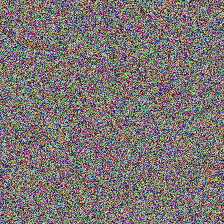

In [39]:
transforms.functional.to_pil_image(unnormalize(random_img)[0])

We now want to move this `random_img` as close to the decision boundary as possible. However, we don't know where that decision boundary is, we know it passes between our `img_tensor` and our `random_img` somewhere. To find the boundary, we use bisection search. Loosely, we look at the point exactly in the middle of the line connecting the two images to see which side of the decision boundary must fall on. We then split that interval in half to find which quarter of the line the decision boundary falls within, and so on until we are arbitrarily close.

In this case, we're going to us a heuristic value for 'arbitrarily close' (made up) that depends on the size of the image. You can safely ignore this code just understand we can use this value to define how close or how far we want to be from the decision boundary. 

In [10]:
# DO NOT CHANGE

threshold = 0.01 / torch.sqrt(torch.prod(torch.tensor(img_tensor.shape, dtype=torch.float).to(img_tensor.device)))
print(f"Threshold for ending the binary search is: {threshold:.10f}")

Threshold for ending the binary search is: 0.0000257746


Think about it this way, the decision boundary is between `100%` and `0%` of the way from our original image to our random image. If we jump `50%` of the way there, what output do we get -- do we need to make more changes or less? Bisection search is something you might be familiar  with from l33t coding interviews. 

In [13]:
# DO NOT CHANGE

upper_bound, lower_bound = 1,0 

while (upper_bound - lower_bound) > threshold:
    midpoint = (upper_bound + lower_bound) / 2.0
    
    interpolated_sample = (1 - midpoint) * img_tensor + midpoint * random_img
    
    if adversarial_satisfactory(interpolated_sample, y_original, clip_min, clip_max):
        # the decision boundary lies between midpoint and lower
        upper_bound, lower_bound = midpoint, lower_bound
    else:
        # it's the other way
        upper_bound, lower_bound = upper_bound, midpoint
    print("upper:", upper_bound, "lower:", lower_bound)
    
boundary_adversarial_example = (1-upper_bound)*img_tensor + upper_bound*random_img

upper: 0.5 lower: 0
upper: 0.25 lower: 0
upper: 0.25 lower: 0.125
upper: 0.25 lower: 0.1875
upper: 0.25 lower: 0.21875
upper: 0.25 lower: 0.234375
upper: 0.25 lower: 0.2421875
upper: 0.24609375 lower: 0.2421875
upper: 0.244140625 lower: 0.2421875
upper: 0.2431640625 lower: 0.2421875
upper: 0.24267578125 lower: 0.2421875
upper: 0.242431640625 lower: 0.2421875
upper: 0.242431640625 lower: 0.2423095703125
upper: 0.24237060546875 lower: 0.2423095703125
upper: 0.242340087890625 lower: 0.2423095703125
upper: 0.2423248291015625 lower: 0.2423095703125


This `boundary_adversarial_example` sample sits just over the decision boundary with our original image. Let's view it below...

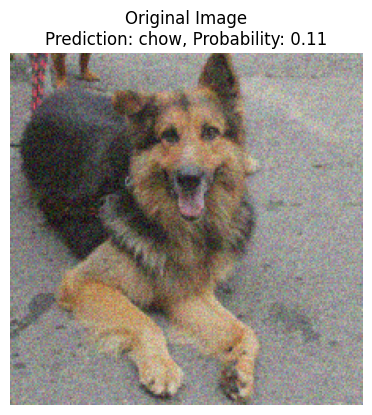

In [14]:
# DO NOT CHANGE

with torch.no_grad():
    output = model(boundary_adversarial_example)
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    prediction = labels[output[0].argmax()]
    
    unnormed_img_tensor= unnormalize(boundary_adversarial_example)
    img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0])

    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')
plt.show()

We could, if we wanted, stop here and use this image; it's been moved close to the boundary and so looks reasonably good, but we can do better.  It turns out that if we move away from the decision boundary in the direction of the gradient, we get a new anchor point which, when we bisect our way back to the decision boundary, will be closer to the original image (and thus look more like it) than the current adversarial example. (This, in part, is what all the gross math in the paper goes to pains to prove.) 

But to do that, we need the gradient, which we can't compute directly because we don't have access to the original model or probabilities - just most-likely class information. The solution, as with so many other approximation techniques, is random sampling, similar to the SimBA approach. In short, we:

1. add a lot of random perturbations to our boundary adversarial example (`gradient_samples=500`)
2. check the classifications to see if they're the original label or not (`eval_samples`)
3. take the mean of the perturbations with the original class, and subtract the mean of the perturbations with the target (incorrect) class

(In the paper they describe a bias corrected version of this, however we're going to opt for a slightly simpler implementation.)

In [15]:
# DO NOT CHANGE

gradient_samples = 500
perturbation_scale = 0.1 * (clip_max - clip_min)  # This is going to be different on subsequent steps -- see page 6 of the paper

# Now we sample
perturbation_shape = [gradient_samples] + list(img_tensor.squeeze(0).shape)

# create our new rando tensors
perturbations = torch.randn(*perturbation_shape).to(device)

# to avoid clipping, we're going to take this noise and renormalize it elementwise
perturbations = perturbations / torch.sqrt(torch.sum(
    perturbations**2,                                     # Mean squared error
    axis = tuple(range(len(perturbation_shape)))[1:],     # We want to normalize each sample individually
    keepdims=True,                                        # but don't change the shape of the result
))

# now make the samples we'll be computing the gradients from
eval_samples = torch.clamp(boundary_adversarial_example + perturbation_scale*perturbations, clip_min, clip_max)

# and label them as being satisfactory or not
eval_labels = adversarial_satisfactory(eval_samples, y_original, clip_min, clip_max)

# and convert to +/-1 to mark which side of the decision boundary they're on
signs = torch.where(eval_labels, 1., -1.)

# and expand to a 4-d tensor bc math
signs = signs.reshape([gradient_samples, 1, 1, 1])

# deal with the edge cases of all samples being of only one class, iykyk
if signs.min()==1.0:  # no -1 means no 'false' satisfactions
    unnormalized_gradient = torch.mean(perturbations, axis = 0)
elif signs.max()==-1.0:
    unnormalized_gradient = -torch.mean(perturbations, axis = 0)
else: #we've got some of each
    mean_signs = torch.mean(signs)
    unnormalized_gradient = torch.mean((signs - mean_signs) * perturbations, axis = 0)

normalized_gradient = unnormalized_gradient / torch.norm(unnormalized_gradient)

And with that, we've got the estimated gradient at the decision boundary -- we can construct a new "anchor" point by stepping away from the decision boundary along that gradient.

:::{exercise} Pop quiz!

Why is the `normalized_gradient` the same shape and size as our `image_tensor`?

:::

The solution to this exercise can be found in the [answer key](answers-2_evasion-closed-box.ipynb).

In the paper, the authors try to take aggressive steps to make the algorithm converge faster with an exponential shrinkage to avoid errors, and the step sizes are derived from some gory math, but all that impacts is "how far" to go, but does not provide a direction, which is what we painfully recovered above. (gradient, think direction!)

In [16]:
# DO NOT CHANGE

# This is a rough ballpark: just "jump _this_ far to the other side of the boundary"
step_size = torch.norm(boundary_adversarial_example - img_tensor)
print(f"Step size: {step_size}")

Step size: 141.66915893554688


In [19]:
# DO NOT CHANGE

done=False
while not done:
    new_anchor = boundary_adversarial_example + step_size * normalized_gradient
    if adversarial_satisfactory(new_anchor, y_original, clip_min, clip_max):
        done=True
    step_size/=2.0 # reduce the step size until we succeed in misclassifying

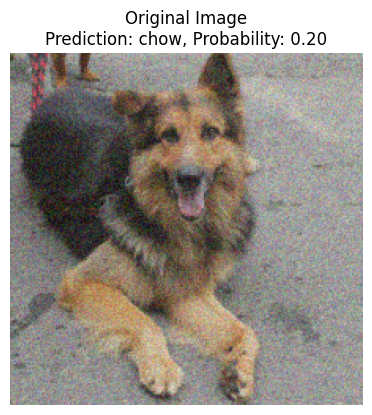

In [18]:
# DO NOT CHANGE

with torch.no_grad():
    output = model(new_anchor)
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    prediction = labels[output[0].argmax()]
    
    unnormed_adv_tensor= unnormalize(new_anchor)
    img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0], 'RGB')

    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')
plt.show()

One thing you might notice immediately is the probability is much higher than in previous examples despite the image being worse. That's because we're finding the decision boundary, as we can't exactly calculate specific points using gradients. You will also see in the chart below, the pixel differences become _much_ larger, and it becomes quite easy to see how a lack of gradients starts to affect the outcome and quality of an attack.

While this is a simplified implementation of the code we'll use later that gives us a very clear image, it does so at a cost of the number of queries it requires. 

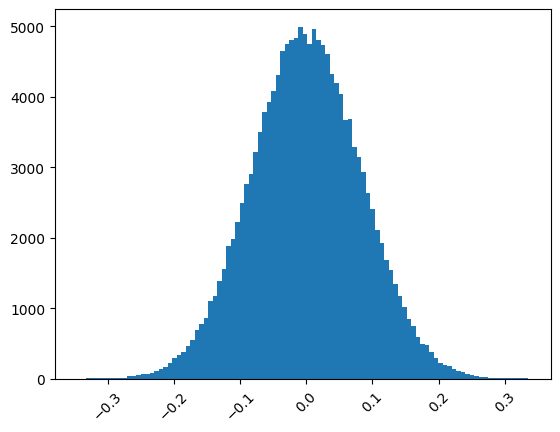

Minimum and maximum difference between the images: -0.34585902094841003 0.33547425270080566


In [20]:
# DO NOT CHANGE

difference = unnormed_adv_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())

:::{exercise} challenge
Repeat the above steps and satisfy yourself of the following:
1. The boundary adversarial example does in fact get closer to the original image in `img_tensor` every time we project then bisect. (think distance!)
2. The distance between the original image and the modified image begins to slowly stabilize to some constant value. (track distance through time)
3. (Optional) Add an early exit criteria to the `HopSkipJump` attack to reduce the number of model calls (don't just reduce the number of iterations; stop in a data-driven way), and compare the results from the full run to the early exit run.  As an attacker, why might you want to early exit from the optimization?
:::

"Why is the `normalized_gradient` the same shape and size as our `img_tensor`"?

A gradient, at its core, is all of a function's partial derivatives. Everything comes back to calculus. 

Say we have a function 

$$
f(x, y) = x^3 + 3y^2
$$ 

This function has **two variables** and therefore **two partial derivatives**. Remember when we take the partial derivative of a function with respect to one variable, we treat all other variables as constants. Using the visual above, you can think of the partial derivative of the function with respect to x at any point 

$$
\frac{\partial{(x^3 + 3y^2)}}{\partial{x}} = 3x^2
$$

$$
\frac{\partial{(x^3 + 3y^2)}}{\partial{y}} = 6y
$$

The gradient of a tensor the partial derivative of a function (a loss function in our case) with respect to each individual element. So the gradient of $f(x, y) = x^3 + 3y^2$ would just be a 2 element vector, $[3x^2, 6y]$. 

The gradient of a function will always have the same number of components as the number of variables in the function. The gradient is a vector of partial derivatives of the loss function with respect to each input element. It shows how the loss changes with small changes in each input dimension. It just so happens in our case that _every_ pixel in the image is a "variable".

The solution for this exercise can be found in the [answer key](answers-2_evasion-closed-box.ipynb).

# Conclusion 
Phew! That was a lot. Like truly a lot. Evasion is a good (but hard) introduction to Adversarial ML, it showcases how optimization can be applied to attacking models as much as it can training them. Just about everything will be easier from here on out. It should be mentioned that optimization is a different field to ML, and you can use this magic in so many other places. The concepts in this lab transfer nicely to security contexts - consider trying to bypass a malware classifier or spam filter. Once you have a data representation an optimizer can work with (numbers), the rest is figuring out how to engineer the attack such that it meets your operational constraints. 

Though, understand there _is_ a cost associated with these attacks. You can distribute traffic, use generative techniques, implement early stopping, "Extract" a model (which is the next lab). You can do any number of clever things; but you will _never_ escape the tension between random and deterministic when it comes to using and attacking models. And consider that, regardless of technique used, algorithms iterate on data in particular ways creating signal in what would otherwise be noise, which has implications for detections.

The optimization mindset is powerful. Once you frame your problems from an optimization perspective -- it's no longer about which techniques go into which bucket -- it's about using the right techniques to drive the outcome you want.

Pat yourself on the back, go grab some coffee, and take a moment to feel like a Mathematics Professor in the hallway.

## What You Learned

1. The concept of evasion with random perturbations.
2. More nuanced attacks to understand efficiency and tradecraft.
3. The differences between _targeted_ and _untargeted_ evasion.
4. How to optimize attacks.
5. How to attack models under both open and closed box conditions.

**Move on to the [Extraction Module](../3_extraction/1_extraction.ipynb)**

![DLI Logo](../assets/DLI_Header.png)